<h1 style="text-align: center;">¿Se puede predecir el comportamiento criminal?</h1>

<center><img src="crime.jpg"/></center>

<h4>Motivación</h4>
En el presente trabajo se analizan un conjunto de datos de reportes donde se detallan los crímenes de Los Angeles en Estados Unidos de América. Todos los datos presentados son obtenidos de una API gubernamental donde se reportan los crimenes sucedidos.
Los datos obtenidos a partir de la API serviran en un futuro para complementar el proyecto "The Murder Accountability Project" que es la más completa base de datos de homicidios en Estados Unidos de América, que se encuentra disponible hasta la fecha y que es el trabajo que fui realizando en la primer parte del curso. 
Este dataset incluye asesinatos de los archivos de Los Angeles y también incluye edad, descripción, sexo, hora, región. También, se incluye la relación entre ellos y el arma utilizada.
El objetivo del estudio de los datos es conocer si se puede detectar el comportamiento de los asesinos y evitar que se produzcan nuevos homicidios a futuro. En este sentido la principal hipótesis seria:

- ¿Es posible predecir el comportamiento criminal?

Para ello podemos plantear ciertas preguntas, con el objetivo de sacar algunas conclusiones (insight)de los datos como por ejemplo:

- ¿Como es la evolucion de la cantidad de crímenes a lo largo del año?
- ¿Como es la evolucion de la cantidad de crímenes de acuerdo a la hora del dia?
- ¿A que sexo son cometidos los crimenes mayormente?
- ¿Como es la distribución de la edad de las víctimas?

Verificadas algunas de las hipótesis podemos plantear la posibilidad de predecir el sexo de los perpetuadores de crimenes entrenando un modelo con los datos que tenemos. 

<h4>Audiencia</h4>

La principal audiencia del correspondiente analisis serian los organismos que intervienen en la reduccion del crimen, como ser policias, detectives, organismos estatales, etc.

Importamos las librerias.

In [78]:
import requests
import pandas as pd
import json

import numpy as np
from IPython.display import Markdown, display

#Librerias graficas:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# Librerias ML:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification


Elegimos un dataset de una API del gobierno de Los Angeles, para complementar con los crimenes que ya teniamos.

In [79]:
APIurl = 'https://data.lacity.org/resource/2nrs-mtv8.json'
response = requests.get(APIurl)

In [80]:
data = response.text
jsondata = json.loads(data)
df = pd.DataFrame.from_dict(jsondata)
df = pd.read_json(data)
df.head()



,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,location,lat,lon,crm_cd_2,cross_street
0,10304468,2020-01-08T00:00:00.000,2020-01-08T00:00:00.000,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,624,1100 W 39TH PL,34.0141,-118.2978,NaN,NaN
1,190101086,2020-01-02T00:00:00.000,2020-01-01T00:00:00.000,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,624,700 S HILL ST,34.0459,-118.2545,NaN,NaN
2,200110444,2020-04-14T00:00:00.000,2020-02-13T00:00:00.000,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,NaN,NaN,AA,Adult Arrest,845,200 E 6TH ST,34.0448,-118.2474,NaN,NaN
3,191501505,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,NaN,NaN,IC,Invest Cont,745,5400 CORTEEN PL,34.1685,-118.4019,998.0,NaN
4,191921269,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,NaN,NaN,IC,Invest Cont,740,14400 TITUS ST,34.2198,-118.4468,NaN,NaN


Realizamos una copia y luego trabajamos sobre el archivo un poco.

In [81]:
LAcrimes_copy = df.copy()

In [82]:
print(df.columns)
#rename columns
df.columns = ['ID', 'Date Reported', 'Date Crime', 'Time', 'Area N', 'Area', 'rpt_dist_no', 'part_1_2', 'crm_cd', 'Crime_Description','mocodes','Victim_Age', 'Victim_Sex', 'Victim_Descent', 'premis_cd','premis_desc','weapon_used_cd','Weapon', 'Status','Status_Desc','crm_cd_1','Location','Latitude', 'Longitud', 'crm_cd_2', 'cross_street']
cols_to_drop = ['rpt_dist_no','Area N','Status', 'part_1_2', 'crm_cd','weapon_used_cd','mocodes', 'premis_cd','premis_desc','crm_cd_1', 'crm_cd_2', 'cross_street']


Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'location', 'lat', 'lon', 'crm_cd_2', 'cross_street'],
      dtype='object')


In [83]:
df.drop(columns = cols_to_drop, inplace= True)
df.head()

,ID,Date Reported,Date Crime,Time,Area,Crime_Description,Victim_Age,Victim_Sex,Victim_Descent,Weapon,Status_Desc,Location,Latitude,Longitud
0,10304468,2020-01-08T00:00:00.000,2020-01-08T00:00:00.000,2230,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978
1,190101086,2020-01-02T00:00:00.000,2020-01-01T00:00:00.000,330,Central,BATTERY - SIMPLE ASSAULT,25,M,H,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545
2,200110444,2020-04-14T00:00:00.000,2020-02-13T00:00:00.000,1200,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,NaN,Adult Arrest,200 E 6TH ST,34.0448,-118.2474
3,191501505,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,1730,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,NaN,Invest Cont,5400 CORTEEN PL,34.1685,-118.4019
4,191921269,2020-01-01T00:00:00.000,2020-01-01T00:00:00.000,415,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,NaN,Invest Cont,14400 TITUS ST,34.2198,-118.4468


In [84]:
df[['Date Reported','Time Reported']] = df['Date Reported'].str.split('T', expand = True)
df[['Date Crime','Time Crime']] = df['Date Crime'].str.split('T', expand = True)
df.drop(columns= ['Time Reported','Time Crime'], inplace= True)
df['Date Reported'] = df['Date Reported'].astype('datetime64[ns]')
df['Date Crime'] = df['Date Crime'].astype('datetime64[ns]')
print(df[['Date Reported','Date Crime']])
df.info()
df.head()

    Date Reported Date Crime
0      2020-01-08 2020-01-08
1      2020-01-02 2020-01-01
2      2020-04-14 2020-02-13
3      2020-01-01 2020-01-01
4      2020-01-01 2020-01-01
..            ...        ...
995    2020-01-29 2020-01-28
996    2020-01-29 2020-01-29
997    2020-01-29 2020-01-28
998    2021-12-16 2020-12-09
999    2020-01-11 2020-01-11

[1000 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 1000 non-null   int64         
 1   Date Reported      1000 non-null   datetime64[ns]
 2   Date Crime         1000 non-null   datetime64[ns]
 3   Time               1000 non-null   int64         
 4   Area               1000 non-null   object        
 5   Crime_Description  1000 non-null   object        
 6   Victim_Age         1000 non-null   int64         
 7   Victim_Sex         93

,ID,Date Reported,Date Crime,Time,Area,Crime_Description,Victim_Age,Victim_Sex,Victim_Descent,Weapon,Status_Desc,Location,Latitude,Longitud
0,10304468,2020-01-08,2020-01-08,2230,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978
1,190101086,2020-01-02,2020-01-01,330,Central,BATTERY - SIMPLE ASSAULT,25,M,H,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545
2,200110444,2020-04-14,2020-02-13,1200,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,NaN,Adult Arrest,200 E 6TH ST,34.0448,-118.2474
3,191501505,2020-01-01,2020-01-01,1730,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,NaN,Invest Cont,5400 CORTEEN PL,34.1685,-118.4019
4,191921269,2020-01-01,2020-01-01,415,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,NaN,Invest Cont,14400 TITUS ST,34.2198,-118.4468


In [85]:
def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null/len(data)*100
    print(data_null)
    print(data_null.plot(kind='bar', figsize=(15, 7), color='#A1B2EC', title='Missing values per category', fontsize=15))

                Count
Weapon           60.8
Victim_Sex        6.2
Victim_Descent    6.2
AxesSubplot(0.125,0.125;0.775x0.755)


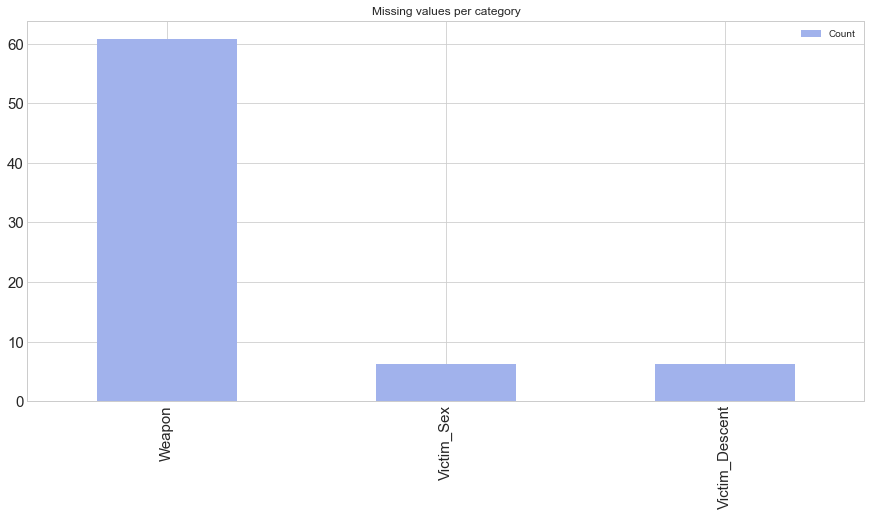

In [86]:
print_missing_values(df)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 1000 non-null   int64         
 1   Date Reported      1000 non-null   datetime64[ns]
 2   Date Crime         1000 non-null   datetime64[ns]
 3   Time               1000 non-null   int64         
 4   Area               1000 non-null   object        
 5   Crime_Description  1000 non-null   object        
 6   Victim_Age         1000 non-null   int64         
 7   Victim_Sex         938 non-null    object        
 8   Victim_Descent     938 non-null    object        
 9   Weapon             392 non-null    object        
 10  Status_Desc        1000 non-null   object        
 11  Location           1000 non-null   object        
 12  Latitude           1000 non-null   float64       
 13  Longitud           1000 non-null   float64       
dtypes: dateti

In [88]:
def handle_missing_values(data):
    df2 = data.copy()
    for col in df:
        df2[col] = df2[col].fillna("Missing value")
    
    return df2

In [89]:
df = handle_missing_values(df)

In [90]:
df.head()

,ID,Date Reported,Date Crime,Time,Area,Crime_Description,Victim_Age,Victim_Sex,Victim_Descent,Weapon,Status_Desc,Location,Latitude,Longitud
0,10304468,2020-01-08,2020-01-08,2230,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978
1,190101086,2020-01-02,2020-01-01,330,Central,BATTERY - SIMPLE ASSAULT,25,M,H,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545
2,200110444,2020-04-14,2020-02-13,1200,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,Missing value,Adult Arrest,200 E 6TH ST,34.0448,-118.2474
3,191501505,2020-01-01,2020-01-01,1730,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,Missing value,Invest Cont,5400 CORTEEN PL,34.1685,-118.4019
4,191921269,2020-01-01,2020-01-01,415,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,Missing value,Invest Cont,14400 TITUS ST,34.2198,-118.4468


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 1000 non-null   int64         
 1   Date Reported      1000 non-null   datetime64[ns]
 2   Date Crime         1000 non-null   datetime64[ns]
 3   Time               1000 non-null   int64         
 4   Area               1000 non-null   object        
 5   Crime_Description  1000 non-null   object        
 6   Victim_Age         1000 non-null   int64         
 7   Victim_Sex         1000 non-null   object        
 8   Victim_Descent     1000 non-null   object        
 9   Weapon             1000 non-null   object        
 10  Status_Desc        1000 non-null   object        
 11  Location           1000 non-null   object        
 12  Latitude           1000 non-null   float64       
 13  Longitud           1000 non-null   float64       
dtypes: dateti

In [93]:
print(len(df['Victim_Age'] == 0))

1000


Como conclusion se realizó un tratamiento de los missing values, de tal forma que los datos quedaron listos para realizar un EDA. La idea seria ir representando los datos de estas tablas de la misma forma o parecida que en el trabajo con el otro dataset, la cual se ira realizando en las proximas entregas.

<h2 align="center">Análisis Exploratorio de Datos</h2>

<h3>¿Como es la evolución de la cantidad de crímenes a lo largo del año?</h3>

Text(0, 0.5, 'Cantidad de crimenes')

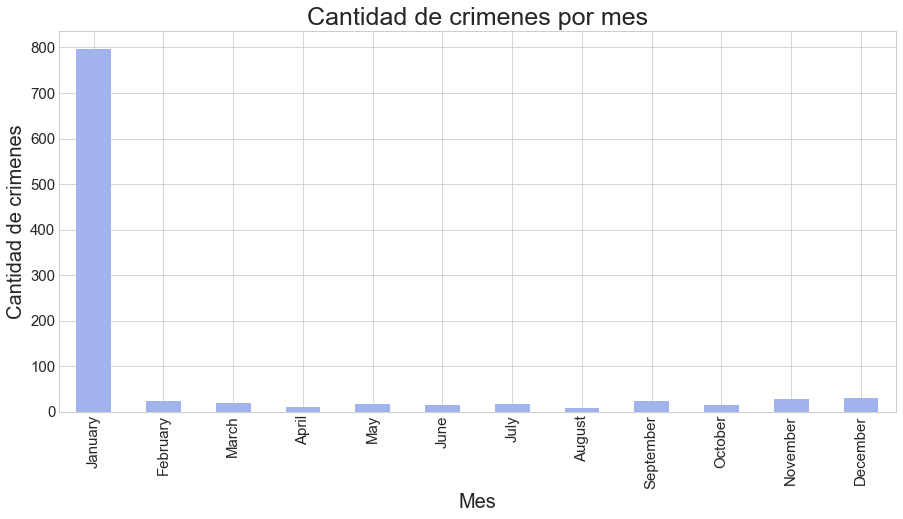

In [94]:
month_crime= df['Date Crime'].dt.month_name()
count_date = month_crime.value_counts()
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# print(count_date)
hom = count_date.reindex(month)
graphic = hom.plot(kind='bar', figsize=(15, 7), color='#A1B2EC', fontsize=15)
graphic.set_title("Cantidad de crimenes por mes", fontsize=25)
graphic.set_xlabel("Mes", fontsize=20)
graphic.set_ylabel("Cantidad de crimenes", fontsize=20)

Aparentemente todos la mayoria de los crimenes han sido cometidos en el primer mes del año, por una gran diferencia.

<h3>¿Como es la evolucion de la cantidad de crímenes de acuerdo a la hora del dia?</h3>

Text(0, 0.5, 'Cantidad de crimenes')

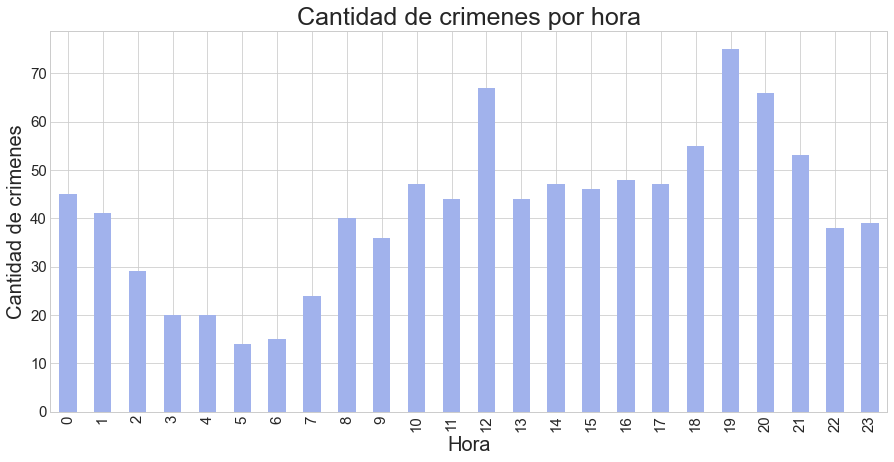

In [95]:
df['Hour'] = df['Time'].astype(str).str[:-2].replace('', 0).astype('int64')
# print(type(df['Hour']))
# df['Hour'].info()
count_hours = df['Hour'].value_counts()
hom = count_hours.sort_index(axis=0, ascending=True)
graphic = hom.plot(kind='bar', figsize=(15, 7), color='#A1B2EC', fontsize=15)
graphic.set_title("Cantidad de crimenes por hora", fontsize=25)
graphic.set_xlabel("Hora", fontsize=20)
graphic.set_ylabel("Cantidad de crimenes", fontsize=20)

Gráfico según la franja horaria. Como para conocer en que momento del día se producen mas crimenes. Evidentemente la franja horaria de menor número de crimenes es la madrigada y la mayor durante el dia. Podemos apreciar que al anochecer se producen la mayor proporcion de los crimenes, entre las 17 y las 22.

<h3>¿A que sexo son cometidos los crimenes mayormente?</h3>

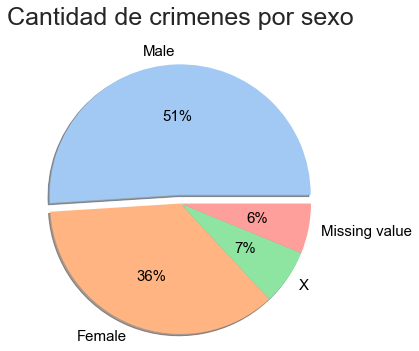

In [100]:
count_sex = df['Victim_Sex'].value_counts()
sex = ['Male', 'Female', 'X', 'Missing value']
colors = sns.color_palette('pastel')[0:5]

plt.pie(count_sex, labels=sex, autopct='%.0f%%', colors=colors, radius=1.5, shadow=True, center=(0, 0), explode=(0.1, 0, 0, 0), textprops={'fontsize': 15, 'color': 'black'})
plt.title(label= 'Cantidad de crimenes por sexo', fontsize=25, loc='center', pad=70, )
plt.show()

Vemos un grafico de torta donde podemos observar que la mayoria de los crimenes son cometidos a personas de sexo masculino.

Text(0.5, 1.0, 'Cantidad de crimenes por hora y sexo')

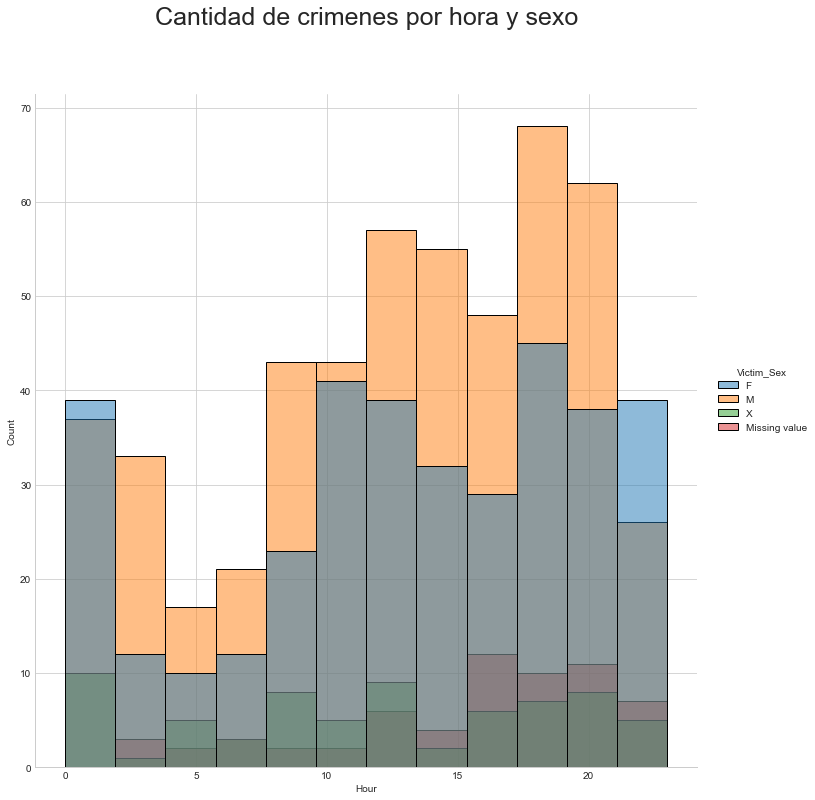

In [97]:
sns.displot(df,x='Hour', hue='Victim_Sex', height=10, aspect=1, color='black')
plt.title(label= 'Cantidad de crimenes por hora y sexo', fontsize=25, loc='center', pad=70)

Una distribucion separando por sexo y hora. Como para ver si existe alguna correlacion entre la hora y el sexo de las victimas. A simple vista no habria correlacion, pero si ya podemos ver que los asesinatos producidos a mujeres son mayores que de los hombres en la mayoria de los momentos del dia.

<h3>¿Como es la distribución de la edad de las víctimas?</h3>

Text(0, 0.5, 'Cantidad de crimenes')

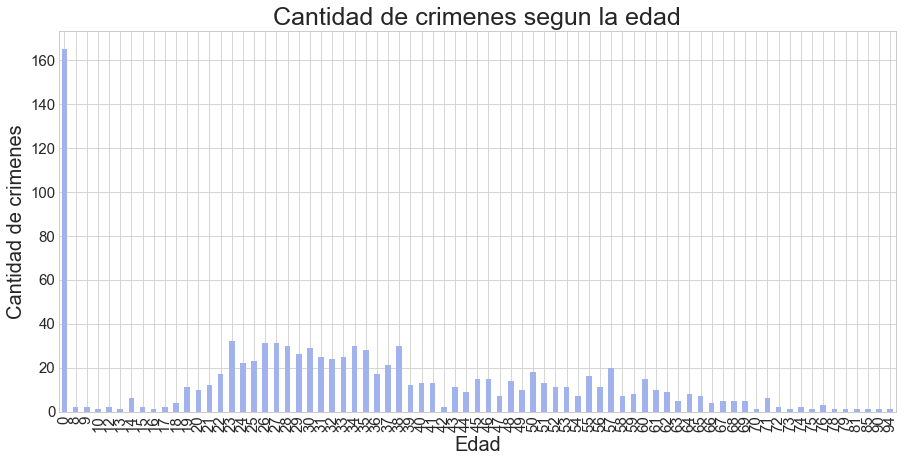

In [98]:
count_age = df['Victim_Age'].value_counts()
hom = count_age.sort_index(axis=0, ascending=True)
graphic = hom.plot(kind='bar', figsize=(15, 7), color='#A1B2EC', fontsize=15)
graphic.set_title("Cantidad de crimenes segun la edad", fontsize=25)
graphic.set_xlabel("Edad", fontsize=20)
graphic.set_ylabel("Cantidad de crimenes", fontsize=20)

Vemos que hay muchos crimenes cometidos a personas con 0 años. Reemplazaremos estos valores por la media de la columna.

Text(0, 0.5, 'Cantidad de crimenes')

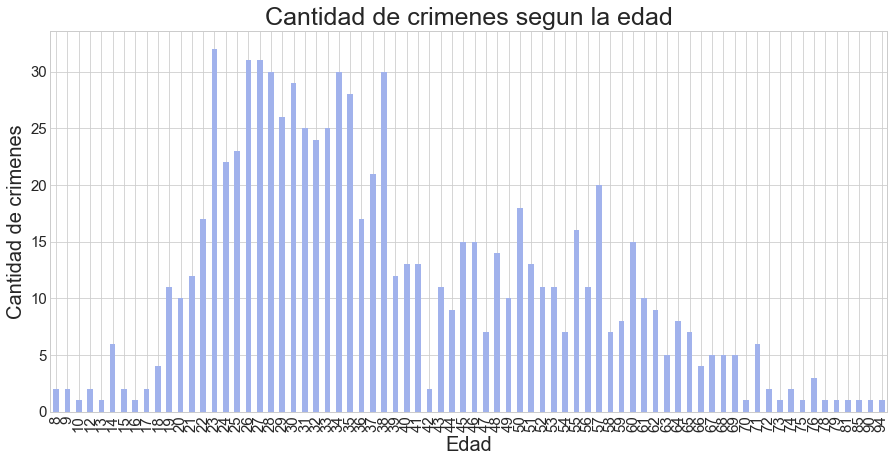

In [99]:
age = df[df['Victim_Age'] > 0]
age = age['Victim_Age'].value_counts()

hom = age.sort_index(axis=0, ascending=True)
graphic = hom.plot(kind='bar', figsize=(15, 7), color='#A1B2EC', fontsize=15)
graphic.set_title("Cantidad de crimenes segun la edad", fontsize=25)
graphic.set_xlabel("Edad", fontsize=20)
graphic.set_ylabel("Cantidad de crimenes", fontsize=20)



Podemos ver que hay una mayor cantidad de crimenes en las edades entre 20 y 40.